# Import Libraries

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import numpy as np

# Obtain Data

Read AirQualityUCI.csv into pandas and isolate PT08.S3(NOx) column for time series

In [195]:
df = pd.read_csv('AirQualityUCI.csv', delimiter=';')
df['Period'] = df['Date'] + ' ' + df['Time']
df = df[['Period','PT08.S3(NOx)']]
df.rename(columns={'PT08.S3(NOx)':'NOx'}, inplace=True)
df.head()

,Period,NOx
0,10/03/2004 18.00.00,1056.0
1,10/03/2004 19.00.00,1174.0
2,10/03/2004 20.00.00,1140.0
3,10/03/2004 21.00.00,1092.0
4,10/03/2004 22.00.00,1205.0


Convert Period column to DateTime format

In [196]:
def reformat_date(date_time):
    return str(date_time).replace('.',':')
df['Period'] = df['Period'].apply(replace_periods)
df['Period'] = pd.to_datetime(df['Period'], dayfirst=True)
df.head()

,Period,NOx
0,2004-03-10 18:00:00,1056.0
1,2004-03-10 19:00:00,1174.0
2,2004-03-10 20:00:00,1140.0
3,2004-03-10 21:00:00,1092.0
4,2004-03-10 22:00:00,1205.0


# Scrub Data

In [197]:
df.drop(labels=range(9357,9471), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Period  9357 non-null   datetime64[ns]
 1   NOx     9357 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 219.3 KB


[Text(0, 0, '3/1/2004'),
 Text(0, 0, '5/3/2004'),
 Text(0, 0, '7/5/2004'),
 Text(0, 0, '9/7/2004'),
 Text(0, 0, '11/9/2004'),
 Text(0, 0, '1/11/2005, 3/16/2005')]

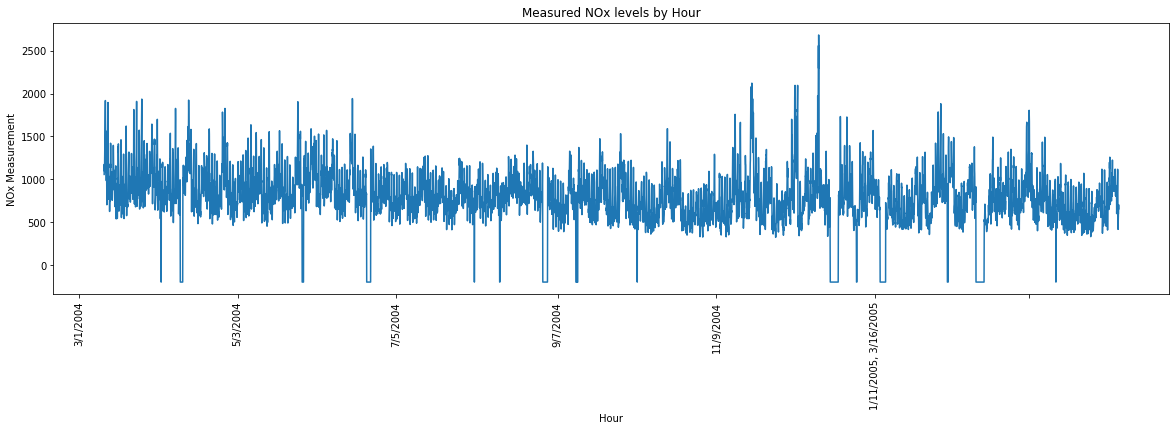

In [198]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['Period'].values,df['NOx'].values)
ax.set_xticklabels(df['Period'].values, rotation=90)
ax.set_title('Measured NOx levels by Hour')
ax.set_ylabel('NOx Measurement')
ax.set_xlabel('Hour')
ax.set_xticklabels(['3/1/2004', '5/3/2004','7/5/2004','9/7/2004','11/9/2004','1/11/2005, 3/16/2005'])


In [199]:
df['NOx'] = df['NOx'].replace({-200: np.nan})
df.fillna(method='ffill', inplace=True)

Text(0.5, 1.0, 'NOx Level by Hour Across 4 Weeks')

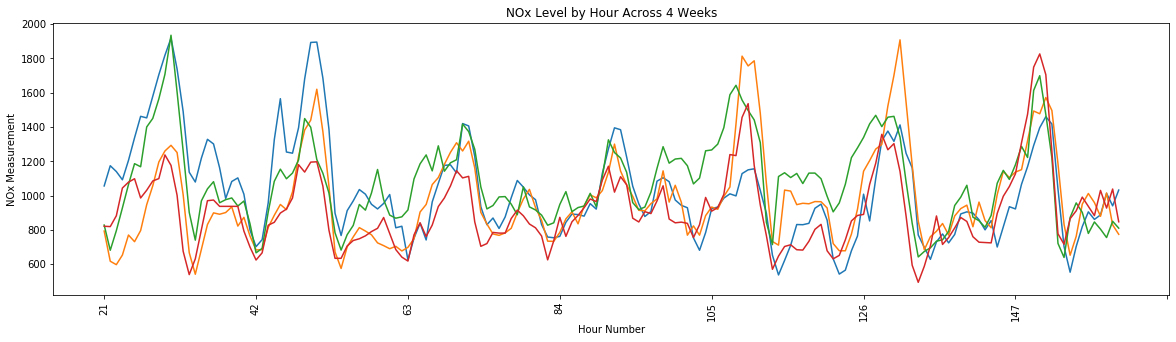

In [201]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(range(0,168),df['NOx'].values[0:168])
ax.plot(range(0,168),df['NOx'].values[168:336])
ax.plot(range(0,168),df['NOx'].values[336:504])
ax.plot(range(0,168),df['NOx'].values[504:672])
ax.set_xticklabels(range(0,168,21), rotation=90)
ax.set_xlabel('Hour Number')
ax.set_ylabel('NOx Measurement')
ax.set_title('NOx Level by Hour Across 4 Weeks')

[Text(0, 0, '2004-03-10T18:00:00.000000000'),
 Text(0, 0, '2004-03-10T19:00:00.000000000'),
 Text(0, 0, '2004-03-10T20:00:00.000000000'),
 Text(0, 0, '2004-03-10T21:00:00.000000000'),
 Text(0, 0, '2004-03-10T22:00:00.000000000'),
 Text(0, 0, '2004-03-10T23:00:00.000000000'),
 Text(0, 0, '2004-03-11T00:00:00.000000000')]

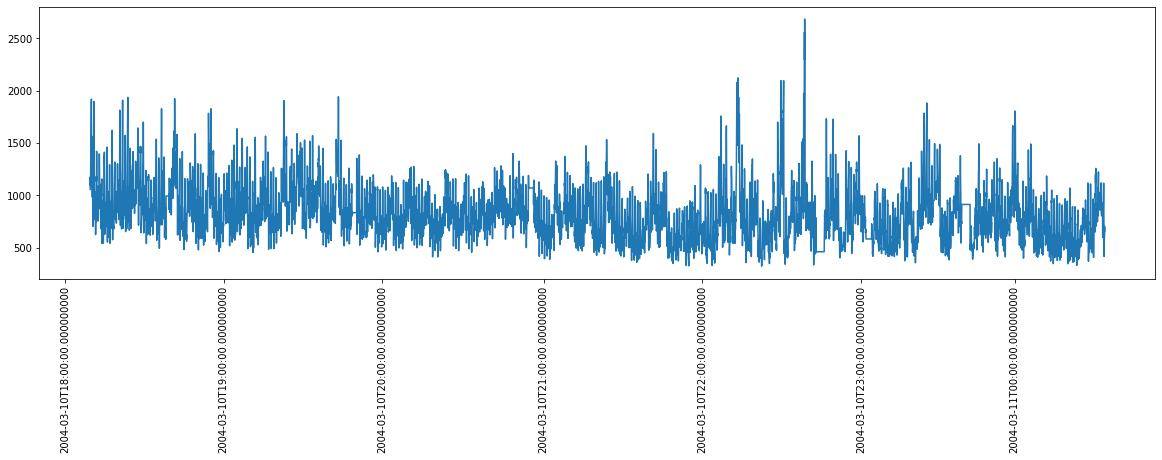

In [154]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['Period'].values,df['NOx'].values)
ax.set_xticklabels(df['Period'].values, rotation=90)

In [155]:
adfuller(df['NOx'])

(-10.604542803529908,
 6.049992360976691e-19,
 36,
 9320,
 {'1%': -3.431051834977192,
  '5%': -2.8618501668189706,
  '10%': -2.5669350967161857},
 109966.50590099777)

# Explore Data

In [156]:
df['NOx'].describe()

count    9357.000000
mean      832.742225
std       255.709423
min       322.000000
25%       655.000000
50%       807.000000
75%       968.000000
max      2683.000000
Name: NOx, dtype: float64

Text(0, 0.5, 'Correlation')

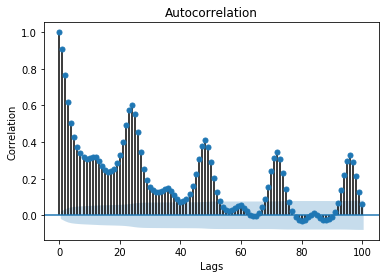

In [205]:
fig, ax = plt.subplots()
plot_acf(df['NOx'], alpha=.05, lags = 100, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Text(0, 0.5, 'Correlation')

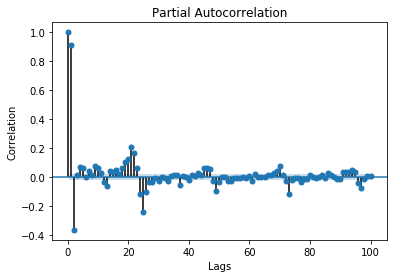

In [207]:
fig2, ax2 = plt.subplots()
plot_pacf(df['NOx'], alpha=.05, lags = 100, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation')

# Model Data

Perform Train Test Split

In [159]:
train_series = df['NOx'].values[:-1488]
val_series = df['NOx'].values[-1488:]

Calculate Persistance RMSE

In [160]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 111.17224723903408
Train MAE: 78.38650228774785
Validation RMSE: 95.99924344019303
Validation MAE: 69.98789509078682


In [161]:
train_mean_predictions = train_series.mean()*1488
train_mean_actuals = train_series
val_mean_predictions = val_series
val_mean_actuals = [train_series.mean()]*1488
#print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
#print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_mean_actuals, val_mean_predictions)))
print('Validation MAE:', mean_absolute_error(val_mean_actuals, val_mean_predictions))

Validation RMSE: 231.55467341771484
Validation MAE: 186.71947290101213


Build SARIMA model

In [171]:
sarima = SARIMAX(train_series, order = (1,1,1), seasonal_order = (1,1,1,24))
sarima_model = sarima.fit()
print(sarima_model.summary())
print(sarima_model.params)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 7869
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -46147.208
Date:                            Sat, 24 Oct 2020   AIC                          92304.416
Time:                                    20:39:19   BIC                          92339.253
Sample:                                         0   HQIC                         92316.352
                                           - 7869                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9060      0.003    269.465      0.000       0.899       0.913
ma.L1         -0.9996      0.001  -

In [172]:
val_pred_sarima = sarima_model.forecast(steps=1488)
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarima))

Validation RMSE: 196.44264393572362
Validation MAE: 164.1184800224251


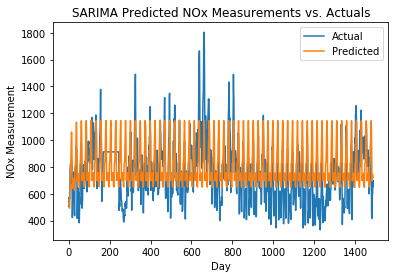

In [226]:
fig, ax = plt.subplots()
ax.plot(range(0,1488),val_series)
ax.plot(range(0,1488),val_pred_sarima)
ax.set_xlabel('Day')
ax.set_ylabel('NOx Measurement')
ax.set_title('SARIMA Predicted NOx Measurements vs. Actuals')
ax.legend(labels = ['Actual','Predicted'])


Build Facebook Prophet Model

In [212]:
fb_df = df.iloc[0:-1488,:]
fb_df.columns = ['ds','y']
prophet = Prophet(interval_width=0.8)
prophet.fit(fb_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [163]:
fb_df.tail()

,ds,y
7864,2005-02-01 10:00:00,503.0
7865,2005-02-01 11:00:00,466.0
7866,2005-02-01 12:00:00,479.0
7867,2005-02-01 13:00:00,497.0
7868,2005-02-01 14:00:00,487.0


In [164]:
df.tail()

,Period,NOx
9352,2005-04-04 10:00:00,539.0
9353,2005-04-04 11:00:00,604.0
9354,2005-04-04 12:00:00,603.0
9355,2005-04-04 13:00:00,702.0
9356,2005-04-04 14:00:00,654.0


In [213]:
prophet_dates_df = prophet.make_future_dataframe(periods=1488, freq='H')
prophet_preds_df = prophet.predict(df=prophet_dates_df)

Text(53.75, 0.5, 'NOx Level')

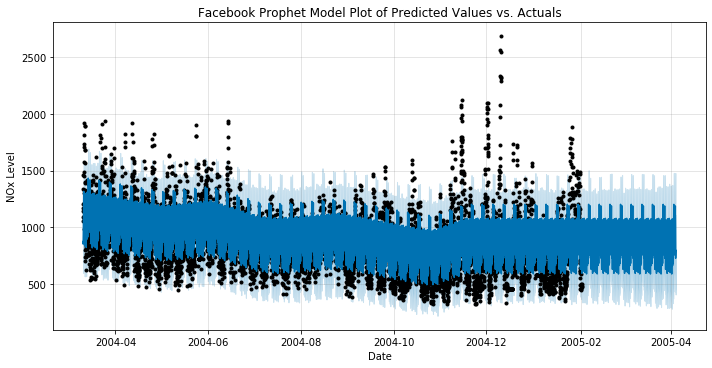

In [222]:
fig3, ax3 = plt.subplots(figsize=(10,5))
prophet.plot(prophet_preds_df, ax=ax3)
ax3.set_title('Facebook Prophet Model Plot of Predicted Values vs. Actuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('NOx Level')

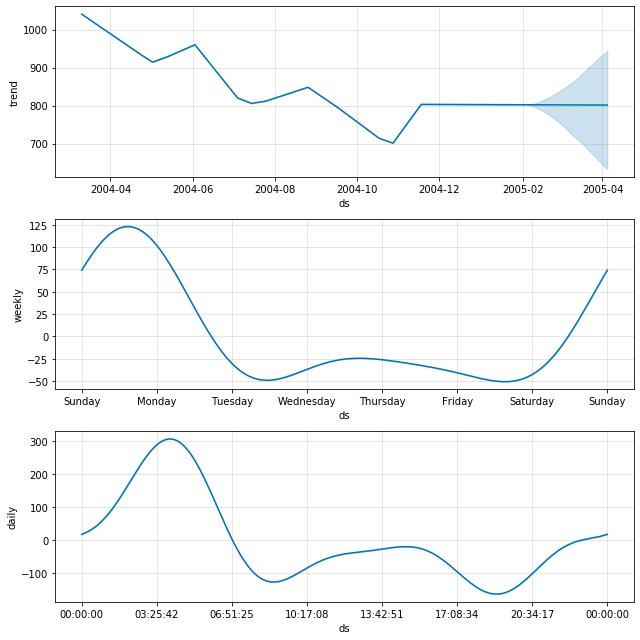

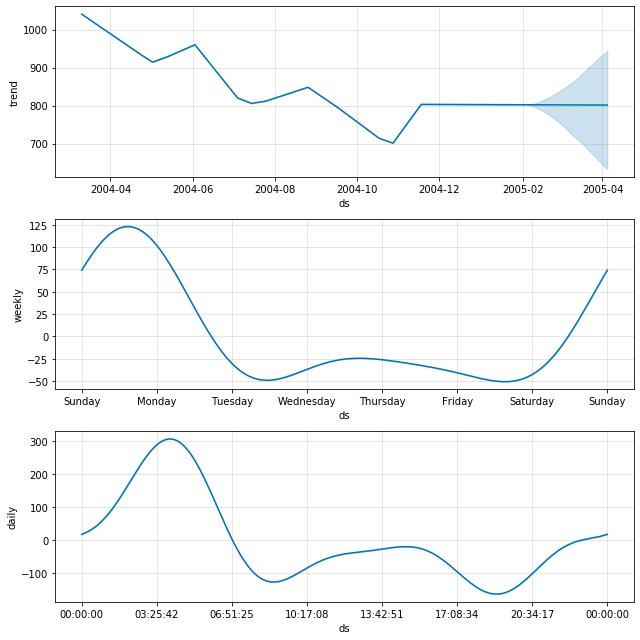

In [215]:
prophet.plot_components(prophet_preds_df)

In [217]:
val_pred_prophet = prophet_preds_df.iloc[-1488:,:]['yhat'].values
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_prophet)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_prophet))

Validation RMSE: 186.89979109830523
Validation MAE: 151.63992045498637
